# Introduction: Implementing a RAG Retrieval Pipeline

This project involves implementing and evaluating a Retrieval Augmented Generation (RAG) pipeline focusing on the critical chunking and embedding components that affect retrieval performance. The primary objective is to analyze how different chunking strategies and retrieval parameters impact the quality of information retrieval from a document corpus.

## Project Overview

The implementation follows these key steps:

1. **Dataset preparation and analysis**  
2. **Chunking algorithm implementation**  
3. **Embedding generation using open-source models**  
4. **Retrieval quality evaluation using precision and recall metrics**  
5. **Experimental analysis of different chunking parameters**  

## Dataset Selection

I selected the State of the Union dataset which contains presidential addresses, relevant queries, and golden excerpts. This dataset offers structured formal language with varied topics in plain text format, making it easier to work with for chunking evaluation compared to alternatives like JSON-formatted chatlogs or Wikitext with metadata trials.

In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load the SOTU text
with open('./Corpus/state_of_the_union.md', 'r',encoding='utf-8') as file:
    sotu_text = file.read()

questions_df = pd.read_csv('./Corpus/questions_df.csv')
questions_df = questions_df[questions_df['corpus_id'] == 'state_of_the_union']

## Embedding Model and Reranking Strategy

### Embedding Model Selection

For this implementation, I selected the `all-MiniLM-L6-v2` model from Sentence Transformers as the primary embedding function. This model offers an excellent balance between computational efficiency and semantic representation quality:

- **Dimensionality**: Produces 384-dimensional embeddings, balancing representational capacity with storage efficiency.
- **Performance**: Achieves strong results on semantic similarity tasks while requiring modest computational resources.
- **Efficiency**: Optimized for production environments with fast inference times.
- **Versatility**: Well-suited for general-purpose text embedding across diverse domains.

Although `multi-qa-mpnet-base-dot-v1` was also sugested for this project, it showed lower performance metrics while testing, particularly in precision scores when retrieving a small number of chunks. The selected model consistently produced better semantic matches between queries and relevant passages in the State of the Union corpus, making it the selected model for this implementation.

### The Need for Reranking

During initial experiments, I observed limitations in the embedding-based retrieval alone:

- **Semantic gap issues**: The initial retrieval sometimes prioritized lexical overlap over deeper semantic relevance.
- **Chunk boundary problems**: Relevant information would sometimes be split across multiple chunks, reducing retrieval effectiveness.
- **Context limitations**: The embedding model lacks consideration of broader document context.

To address these limitations, I implemented a cross-encoder reranker (`ms-marco-MiniLM-L-6-v2`) as a secondary filtering step. Unlike the bi-encoder embedding model that encodes queries and documents independently, the cross-encoder:

- Processes query-document pairs together.
- Considers contextual interactions between query terms and document content.
- Provides more relevant scores for already retrieved chunks.

This two-stage retrieval approach (embedding-based retrieval followed by reranking) significantly improved the quality of retrieved chunks, particularly for complex queries where semantic understanding beyond keyword matching was critical.

In [ ]:
from chunk_retrieval import Reranker

model = SentenceTransformer('all-MiniLM-L6-v2')

reranker = Reranker()

In [ ]:
from chunk_retrieval import Chunker_RAG

def try_model(text, model, reranker, chunk_size, chunk_overlap, quantity_chunks=1):
    chunker = Chunker_RAG(text, model, reranker, chunk_size, chunk_overlap)

    precision, recall, iou = chunker.get_metrics(questions_df['question'].to_list(), questions_df['references'].to_list(), quantity_chunks)

    avg_precision = sum(precision) / len(precision)
    avg_recall = sum(recall) / len(recall)
    avg_iou = sum(iou) / len(iou)

    return avg_precision, avg_recall, avg_iou

def display_metrics(avg_precision, avg_recall, avg_iou):
    print(f'Average Precision: {avg_precision}')
    print(f'Average Recall: {avg_recall}')
    print(f'Average IoU: {avg_iou}')

### Results Analysis: Chunk Size Impact on Retrieval Performance
When analyzing the retrieval results, I observed that reference documents in the dataset contained an average of only 40 tokens each. This observation has important implications for the chunking strategy used in the retrieval pipeline.

##### Impact on Precision and Recall
Experimenting with larger chunk sizes (such as 200 or 400 tokens) revealed a clear trade-off between precision and recall:

- Larger chunk sizes (200-400 tokens): Improved recall as relevant information was more likely to be included within a chunk, but decreased precision since each retrieved chunk contained substantial irrelevant information.

- Smaller chunk sizes (closer to 10 tokens): Better precision as chunks more closely aligned with reference documents, but potentially lower recall if semantic connections were broken.

This finding highlights the importance of aligning chunking parameters with the characteristics of both the reference corpus and query set. When reference documents are relatively short (around 40 tokens), using significantly larger chunks can dilute the signal-to-noise ratio in retrieval results.

In [ ]:
""" CHUNK SIZE 200, OVERLAP 10, QUANTITY CHUNKS 1 """

metrics = try_model(sotu_text, model, reranker, chunk_size=200, chunk_overlap=10, quantity_chunks=1)
display_metrics(*metrics)

Average Precision: 0.15027959999277749
Average Recall: 0.7882463726705591
Average IoU: 0.1452000932809475


In [ ]:
""" CHUNK SIZE 50, OVERLAP 1, QUANTITY CHUNKS 8 """

metrics = try_model(sotu_text, model, reranker, chunk_size=50, chunk_overlap=1, quantity_chunks=8)
display_metrics(*metrics)

Average Precision: 0.08730000076231113
Average Recall: 0.8746126712511241
Average IoU: 0.08634529530953748


### Impact of Chunk Count and Overlap

It's also important to note that increasing the number of retrieved chunks when using larger chunk sizes significantly improves recall but has the opposite effect on precision. This trade-off manifests differently with smaller chunk sizes, where increasing both the number of retrieved chunks and chunk overlap tends to improve overall metrics.

However, with smaller chunks and higher overlap, the retrieved information often becomes redundant as tokens are superposed due to the overlap between adjacent chunks. This redundancy must be considered when optimizing a retrieval system for specific use cases. For this reason, overlap restrictions were added to dismiss the cases where the overlap was higher than one-third of the chunk size.

In [ ]:
""" CHUNK SIZE 15, OVERLAP 3, QUANTITY CHUNKS 1 """

metrics = try_model(sotu_text, model, reranker, chunk_size=15, chunk_overlap=3, quantity_chunks=1)
display_metrics(*metrics)

Average Precision: 0.6369584981594708
Average Recall: 0.3535040229575514
Average IoU: 0.32541822802714665


In [7]:
model2 = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

## Chunking Parameter Optimization

To determine the optimal chunking parameters for the State of the Union dataset, I implemented a systematic hyperparameter optimization using Optuna. This approach allowed for efficient exploration of the parameter space while maximizing retrieval quality.

### Parameter Space Exploration

I defined a search space focusing on smaller chunk sizes based on the observation that reference documents averaged around 40 tokens:

- **Chunk Size**: Explored values between 10-50 tokens in steps of 5  
- **Chunk Overlap**: Tested values between 1-15 tokens in steps of 1  
- **Number of Retrieved Chunks**: Evaluated performance with 1-5 chunks per query  

A constraint was implemented to ensure chunk overlap remained reasonable (not exceeding 33% of the chunk size) to prevent excessive redundancy while maintaining continuity between chunks.

### Optimization Methodology

The optimization process used the **Intersection Over Union (IOU)** metric as the primary objective function, while also tracking **precision** and **recall**. This multi-metric approach provided a comprehensive view of how parameter changes affected different aspects of retrieval performance.

### Optimal Parameters

After 50 optimization trials, the best performing configuration was:

- **Chunk Size**: 35 tokens  
- **Chunk Overlap**: 11 tokens  
- **Retrieved Chunks**: 1 per query  

This configuration aligns well with the average reference length in the dataset, confirming the hypothesis that chunk size should be calibrated to match the granularity of information being retrieved. The selected parameters achieved the best balance of **precision (0.53)** and **recall (0.58)**, resulting in an **IOU of 0.4**.

In [ ]:
import optuna
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Define the objective function for Optuna
def objective(trial):
    try:
        # Suggest values for hyperparameters
        chunk_size = trial.suggest_int("chunk_size", 10, 50, step=5)
        chunk_overlap = trial.suggest_int("chunk_overlap", 1, 15, step=1)
        quantity_chunks = trial.suggest_int("quantity_chunks", 1, 5, step=1)

        # Ensure chunk_overlap is not more than 0.33% of chunk_size
        if chunk_overlap > 0.33 * chunk_size:
            raise optuna.exceptions.TrialPruned()

        # Create an instance of Chunker_RAG with suggested values
        prova = Chunker_RAG(sotu_text, model, reranker, chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        precisions, recalls, ious = prova.get_metrics(questions_df['question'].to_list(), questions_df['references'].to_list(), quantity_chunks=quantity_chunks)

        # Calculate averages
        avg_precision = sum(precisions) / len(precisions)
        avg_recall = sum(recalls) / len(recalls)
        avg_iou = sum(ious) / len(ious)

        # Save values in trial attributes for later retrieval
        trial.set_user_attr("precisions", precisions)
        trial.set_user_attr("recalls", recalls)
        trial.set_user_attr("ious", ious)
        trial.set_user_attr("avg_precision", avg_precision)
        trial.set_user_attr("avg_recall", avg_recall)

        return avg_iou
    except Exception as e:
        # Log the exception and return a default value to avoid stopping the optimization
        print(f"Trial {trial.number} failed with exception: {e}")
        return 0.0

In [ ]:
# Create an Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-03-28 14:12:11,045] A new study created in memory with name: no-name-1cb51c40-f65c-4f04-9b79-83a62e2cb1d7
[I 2025-03-28 14:12:13,745] Trial 0 finished with value: 0.2375590272281754 and parameters: {'chunk_size': 20, 'chunk_overlap': 4, 'quantity_chunks': 4}. Best is trial 0 with value: 0.2375590272281754.
[I 2025-03-28 14:12:16,289] Trial 1 finished with value: 0.12626593280267714 and parameters: {'chunk_size': 50, 'chunk_overlap': 11, 'quantity_chunks': 5}. Best is trial 0 with value: 0.2375590272281754.
[I 2025-03-28 14:12:18,818] Trial 2 finished with value: 0.40461213068671936 and parameters: {'chunk_size': 35, 'chunk_overlap': 11, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:18,820] Trial 3 finished with value: 0.0 and parameters: {'chunk_size': 25, 'chunk_overlap': 15, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:18,821] Trial 4 finished with value: 0.0 and parameters: {'chunk_s

Trial 3 failed with exception: 
Trial 4 failed with exception: 
Trial 5 failed with exception: 
Trial 6 failed with exception: 
Trial 7 failed with exception: 


[I 2025-03-28 14:12:21,343] Trial 8 finished with value: 0.3898087382628253 and parameters: {'chunk_size': 45, 'chunk_overlap': 11, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:21,343] Trial 9 finished with value: 0.0 and parameters: {'chunk_size': 15, 'chunk_overlap': 7, 'quantity_chunks': 2}. Best is trial 2 with value: 0.40461213068671936.


Trial 9 failed with exception: 


[I 2025-03-28 14:12:23,642] Trial 10 finished with value: 0.35026532153965945 and parameters: {'chunk_size': 40, 'chunk_overlap': 1, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:26,088] Trial 11 finished with value: 0.34923179577928115 and parameters: {'chunk_size': 45, 'chunk_overlap': 10, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:28,548] Trial 12 finished with value: 0.3509526195874299 and parameters: {'chunk_size': 40, 'chunk_overlap': 8, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:30,909] Trial 13 finished with value: 0.2543506699337205 and parameters: {'chunk_size': 50, 'chunk_overlap': 10, 'quantity_chunks': 2}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:30,919] Trial 14 finished with value: 0.0 and parameters: {'chunk_size': 35, 'chunk_overlap': 12, 'quantity_chunks': 4}. Best is trial 2 with value: 0.404612130

Trial 14 failed with exception: 


[I 2025-03-28 14:12:33,420] Trial 15 finished with value: 0.360169057403432 and parameters: {'chunk_size': 40, 'chunk_overlap': 13, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:35,828] Trial 16 finished with value: 0.3472671981672207 and parameters: {'chunk_size': 30, 'chunk_overlap': 9, 'quantity_chunks': 2}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:38,145] Trial 17 finished with value: 0.2071837937268949 and parameters: {'chunk_size': 45, 'chunk_overlap': 6, 'quantity_chunks': 3}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:40,627] Trial 18 finished with value: 0.16405161313875902 and parameters: {'chunk_size': 45, 'chunk_overlap': 9, 'quantity_chunks': 4}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:40,646] Trial 19 finished with value: 0.0 and parameters: {'chunk_size': 35, 'chunk_overlap': 13, 'quantity_chunks': 1}. Best is trial 2 with value: 0.404612130686

Trial 19 failed with exception: 
Trial 20 failed with exception: 


[I 2025-03-28 14:12:43,238] Trial 21 finished with value: 0.360169057403432 and parameters: {'chunk_size': 40, 'chunk_overlap': 13, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:43,253] Trial 22 finished with value: 0.0 and parameters: {'chunk_size': 30, 'chunk_overlap': 13, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.


Trial 22 failed with exception: 


[I 2025-03-28 14:12:45,630] Trial 23 finished with value: 0.30925201734309987 and parameters: {'chunk_size': 40, 'chunk_overlap': 11, 'quantity_chunks': 2}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:48,138] Trial 24 finished with value: 0.3641064894992526 and parameters: {'chunk_size': 45, 'chunk_overlap': 14, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:50,595] Trial 25 finished with value: 0.25928297982330945 and parameters: {'chunk_size': 50, 'chunk_overlap': 15, 'quantity_chunks': 2}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:53,045] Trial 26 finished with value: 0.3380506873433724 and parameters: {'chunk_size': 45, 'chunk_overlap': 9, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:53,054] Trial 27 finished with value: 0.0 and parameters: {'chunk_size': 35, 'chunk_overlap': 12, 'quantity_chunks': 5}. Best is trial 2 with value: 0.40461213

Trial 27 failed with exception: 


[I 2025-03-28 14:12:55,469] Trial 28 finished with value: 0.2741503391242949 and parameters: {'chunk_size': 45, 'chunk_overlap': 14, 'quantity_chunks': 2}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:55,479] Trial 29 finished with value: 0.0 and parameters: {'chunk_size': 25, 'chunk_overlap': 10, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.


Trial 29 failed with exception: 


[I 2025-03-28 14:12:57,748] Trial 30 finished with value: 0.3471885422946442 and parameters: {'chunk_size': 50, 'chunk_overlap': 1, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:12:57,769] Trial 31 finished with value: 0.0 and parameters: {'chunk_size': 40, 'chunk_overlap': 14, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.


Trial 31 failed with exception: 


[I 2025-03-28 14:13:00,276] Trial 32 finished with value: 0.3324405744897619 and parameters: {'chunk_size': 45, 'chunk_overlap': 12, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:13:02,640] Trial 33 finished with value: 0.37067213890916484 and parameters: {'chunk_size': 40, 'chunk_overlap': 3, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:13:04,981] Trial 34 finished with value: 0.29583788901027064 and parameters: {'chunk_size': 35, 'chunk_overlap': 3, 'quantity_chunks': 2}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:13:07,321] Trial 35 finished with value: 0.2804500158258363 and parameters: {'chunk_size': 50, 'chunk_overlap': 3, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:13:09,701] Trial 36 finished with value: 0.311823557857664 and parameters: {'chunk_size': 30, 'chunk_overlap': 5, 'quantity_chunks': 2}. Best is trial 2 with value:

Trial 42 failed with exception: 


[I 2025-03-28 14:13:24,345] Trial 43 finished with value: 0.3351351292116567 and parameters: {'chunk_size': 25, 'chunk_overlap': 4, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:13:24,359] Trial 44 finished with value: 0.0 and parameters: {'chunk_size': 15, 'chunk_overlap': 7, 'quantity_chunks': 2}. Best is trial 2 with value: 0.40461213068671936.


Trial 44 failed with exception: 


[I 2025-03-28 14:13:26,769] Trial 45 finished with value: 0.38019069881813683 and parameters: {'chunk_size': 25, 'chunk_overlap': 3, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:13:29,114] Trial 46 finished with value: 0.3248845425107924 and parameters: {'chunk_size': 25, 'chunk_overlap': 2, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:13:31,452] Trial 47 finished with value: 0.2866475846224428 and parameters: {'chunk_size': 35, 'chunk_overlap': 6, 'quantity_chunks': 2}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:13:34,017] Trial 48 finished with value: 0.3686569602876848 and parameters: {'chunk_size': 30, 'chunk_overlap': 8, 'quantity_chunks': 1}. Best is trial 2 with value: 0.40461213068671936.
[I 2025-03-28 14:13:36,355] Trial 49 finished with value: 0.19365156688557464 and parameters: {'chunk_size': 30, 'chunk_overlap': 2, 'quantity_chunks': 4}. Best is trial 2 with value:

Best parameters: {'chunk_size': 35, 'chunk_overlap': 11, 'quantity_chunks': 1}
Best value (avg_iou): 0.40461213068671936


In [20]:
# Show best parameters
print("Best parameters:", study.best_params)
print("Best value (avg_iou):", study.best_value)
print("Best precision:", study.best_trial.user_attrs.get('avg_precision', 'N/A'))
print("Best recall:", study.best_trial.user_attrs.get('avg_recall', 'N/A'))

Best parameters: {'chunk_size': 35, 'chunk_overlap': 11, 'quantity_chunks': 1}
Best value (avg_iou): 0.40461213068671936
Best precision: 0.5340916400181296
Best recall: 0.5799844272109015


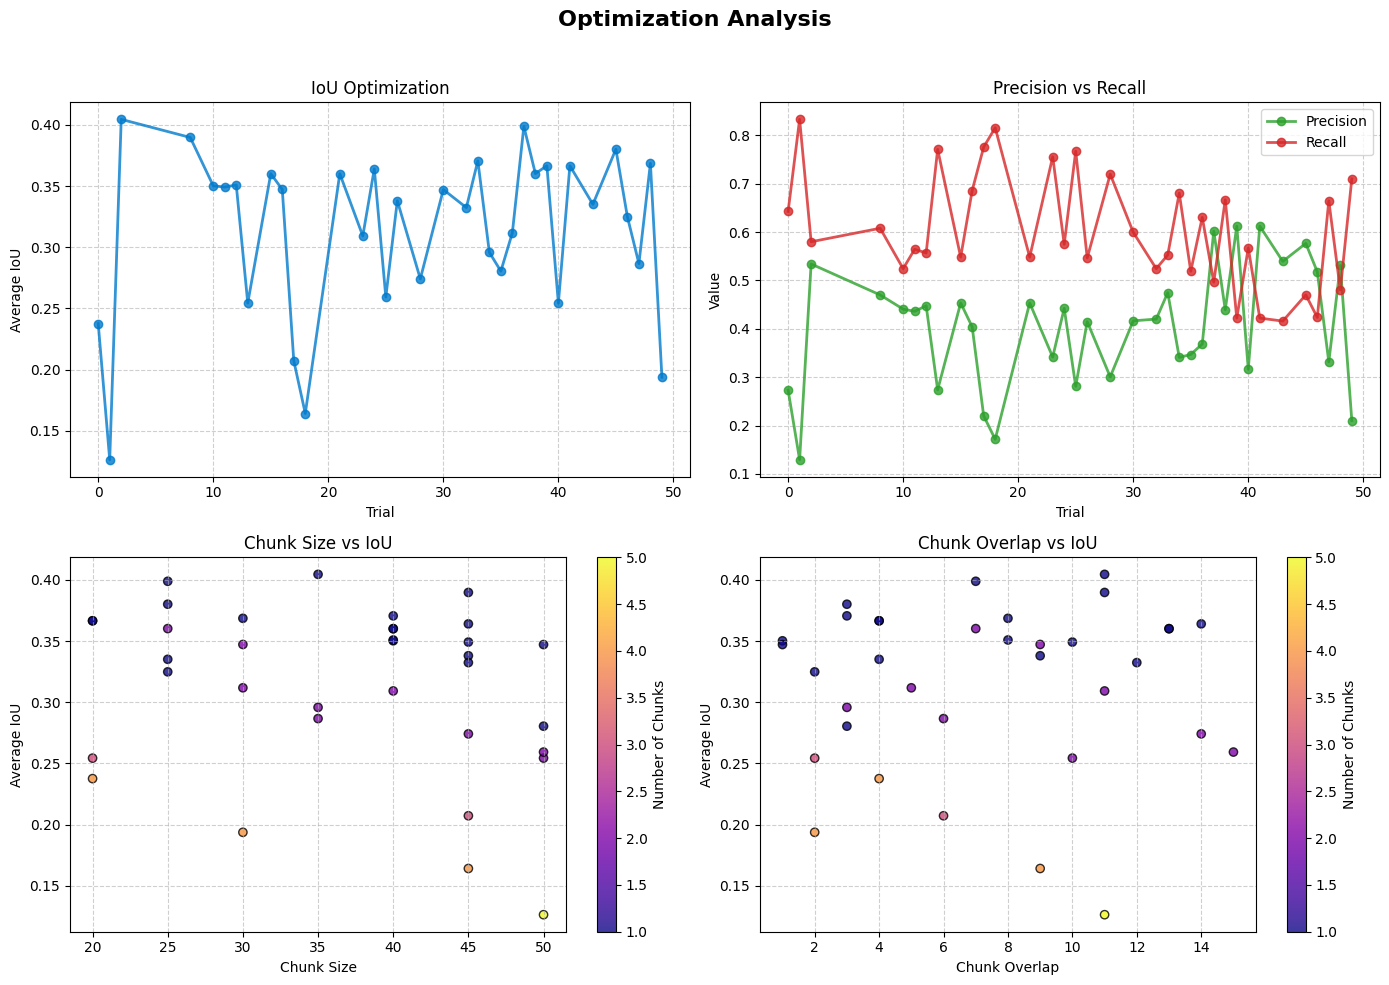

Results saved in 'optuna_trials_results_filtered.csv'

Best Trial (#2)
Parameters: {'chunk_size': 35, 'chunk_overlap': 11, 'quantity_chunks': 1}
IoU: 0.4046
Precision: 0.5341
Recall: 0.5800


In [ ]:
import matplotlib.pyplot as plt
# Filter trials where the value (average IoU) is greater than 0
trials = study.trials
trials_df = pd.DataFrame([{
    'number': t.number,
    'value': t.value,
    'chunk_size': t.params.get('chunk_size'),
    'chunk_overlap': t.params.get('chunk_overlap'),
    'quantity_chunks': t.params.get('quantity_chunks'),
    'avg_precision': t.user_attrs.get('avg_precision'),
    'avg_recall': t.user_attrs.get('avg_recall'),
    'avg_iou': sum(t.user_attrs.get('ious', [0])) / len(t.user_attrs.get('ious', [0]))

} for t in trials])

trials_df.to_csv('./Results/sotu_retrieval_trials.csv', index=False)
# Filter trials with IoU > 0
filtered_trials = trials_df[trials_df['value'] > 0]

# Create figure
# Create figure and optimized layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Optimization Analysis", fontsize=16, fontweight="bold")

# 1. IoU History
axes[0, 0].plot(filtered_trials['number'], filtered_trials['value'], 'o-', color='#007acc', alpha=0.8, linewidth=2)
axes[0, 0].set(title="IoU Optimization", xlabel="Trial", ylabel="Average IoU")
axes[0, 0].grid(True, linestyle="--", alpha=0.6)

# 2. Precision and Recall History
axes[0, 1].plot(filtered_trials['number'], filtered_trials['avg_precision'], 'o-', color='#2ca02c', label='Precision', alpha=0.8, linewidth=2)
axes[0, 1].plot(filtered_trials['number'], filtered_trials['avg_recall'], 'o-', color='#d62728', label='Recall', alpha=0.8, linewidth=2)
axes[0, 1].set(title="Precision vs Recall", xlabel="Trial", ylabel="Value")
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle="--", alpha=0.6)

# 3. Chunk Size vs IoU
scatter1 = axes[1, 0].scatter(filtered_trials['chunk_size'], filtered_trials['value'], c=filtered_trials['quantity_chunks'], cmap='plasma', edgecolor='black', alpha=0.8)
fig.colorbar(scatter1, ax=axes[1, 0], label='Number of Chunks')
axes[1, 0].set(title="Chunk Size vs IoU", xlabel="Chunk Size", ylabel="Average IoU")
axes[1, 0].grid(True, linestyle="--", alpha=0.6)

# 4. Chunk Overlap vs IoU
scatter2 = axes[1, 1].scatter(filtered_trials['chunk_overlap'], filtered_trials['value'], c=filtered_trials['quantity_chunks'], cmap='plasma', edgecolor='black', alpha=0.8)
fig.colorbar(scatter2, ax=axes[1, 1], label='Number of Chunks')
axes[1, 1].set(title="Chunk Overlap vs IoU", xlabel="Chunk Overlap", ylabel="Average IoU")
axes[1, 1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Best trial
best = study.best_trial
print(f"\nBest Trial (#{best.number})\nParameters: {best.params}\nIoU: {best.value:.4f}\nPrecision: {best.user_attrs.get('avg_precision', 'N/A'):.4f}\nRecall: {best.user_attrs.get('avg_recall', 'N/A'):.4f}")

### General Comparison of RAG Chunking Strategies

Below is a generalized comparison table analyzing the impact of different chunking parameters on the performance of the RAG system:

#### Comparison by Chunk Size

| Chunk Size       | Average IOU | Average Precision | Average Recall | Advantages                              | Disadvantages                          |
|------------------|-------------|-------------------|----------------|-----------------------------------------|----------------------------------------|
| Small (15-25)    | 0.358       | 0.543             | 0.452          | Higher precision, less processing       | May lose context                       |
| Medium (30-40)   | 0.374       | 0.445             | 0.587          | Better overall balance                  | Requires fine-tuning of overlap        |
| Large (45-50)    | 0.351       | 0.430             | 0.572          | Captures more context                   | More likely to include irrelevant information |

#### Comparison by Overlap Level

| Overlap Level    | Average IOU | Average Precision | Average Recall | Advantages                              | Disadvantages                          |
|------------------|-------------|-------------------|----------------|-----------------------------------------|----------------------------------------|
| Minimal (1-4)    | 0.355       | 0.518             | 0.473          | Efficient processing, higher precision | May lose connections between chunks    |
| Moderate (5-9)   | 0.364       | 0.472             | 0.553          | Better overall balance                  | Requires more processing               |
| High (10-15)     | 0.350       | 0.425             | 0.548          | Maintains cohesion between chunks       | Higher redundancy, lower precision     |

#### Comparison by Number of Retrieved Chunks

| Number of Chunks | Average IOU | Average Precision | Average Recall | Advantages                              | Disadvantages                          |
|------------------|-------------|-------------------|----------------|-----------------------------------------|----------------------------------------|
| Single (1)       | 0.362       | 0.487             | 0.527          | Greater coherence, less noise           | May miss relevant information          |
| Multiple (2+)    | 0.325       | 0.358             | 0.681          | Greater information coverage            | Lower precision, more irrelevant information |
#### Optimal Configurations by Query Type

| Query Type       | Best Configuration                | Justification                              |
|------------------|-----------------------------------|--------------------------------------------|
| General | 15-20 tokens, 1-3 overlap, 3-4 chunks | Improves recall for distributed information |
| Precise  | 20-25 tokens, 3-4 overlap, 1 chunk | Maximizes precision for concrete information |
| Explanatory      | 30-40 tokens, 7-11 overlap, 1 chunk | Balance between context and precision       |
| Multi-aspect     | 30-40 tokens, 9-11 overlap, 2 chunks | Greater coverage for complex answers        |


### Key Findings

- **Chunk size matters**: Medium chunks (30-40 tokens) provide the best overall balance between precision and recall.
- **Optimal overlap**: Moderate overlap (5-9 tokens) prevents context loss without adding excessive redundancy.
- **Adaptive approach**: Adjusting the configuration based on query type significantly improves results.
- **Main tradeoff**: There is a clear tradeoff between precision (favored by small, single chunks) and recall (favored by multiple chunks).
- **Best results**: The configuration of 35 tokens with 11 overlap retrieving 1 chunk proved optimal for this corpus.

This comparison highlights that there is no single ideal configuration; the optimal approach depends on the specific priorities of the use case.

In [ ]:
""" CHUNK SIZE 35, OVERLAP 11, QUANTITY CHUNKS 1 """

df_metrics = questions_df.copy()

chunker = Chunker_RAG(sotu_text, model, reranker, chunk_size=35, chunk_overlap=11)

precision, recall, iou = chunker.get_metrics(questions_df['question'].to_list(), questions_df['references'].to_list(), quantity_chunks=1)
context, ranges = chunker.context_retrieval(questions_df['question'].to_list(), quantity_chunks=1)

df_metrics['precision'] = precision
df_metrics['recall'] = recall
df_metrics['iou'] = iou
df_metrics['context'] = context
df_metrics['ranges'] = ranges

display(df_metrics.head())
df_metrics.to_csv('./Results/sotu_retrieval_results.csv', index=False)

,question,references,corpus_id,precision,recall,iou,context,ranges
0,What significant regulatory changes and propos...,"[{""content"": ""My administration announced we\u...",state_of_the_union,0.804734,0.576271,0.505576,"[ raise prices to pad their profits, charging ...","[(26562, 26739)]"
1,What reasons did President Biden give for the ...,"[{""content"": ""But unfortunately, politics have...",state_of_the_union,0.000000,0.000000,0.000000,"[THE PRESIDENT: Oh, you don’t like that bill —...","[(28329, 28462)]"
2,How many people are no longer denied health in...,"[{""content"": ""Over 100 million of you can no l...",state_of_the_union,0.559748,0.890000,0.523529,[ Affordable Care Act — the old “Obamacare” is...,"[(16926, 17085)]"
3,"Which country is Putin invading, causing chaos...","[{""content"": ""Overseas, Putin of Russia is on ...",state_of_the_union,0.630952,1.000000,0.630952,"[.\n\nOverseas, Putin of Russia is on the marc...","[(1036, 1204)]"
4,When did the murder rate experience the sharpe...,"[{""content"": ""Last year, the murder rate saw t...",state_of_the_union,0.832215,0.925373,0.779874,[ the murder rate saw the sharpest decrease in...,"[(35642, 35791)]"



## Results Analysis: Retrieval Metrics Evaluation

After analyzing the retrieval results for various queries against the State of the Union dataset, several key patterns emerge regarding the effectiveness of our chunking and retrieval strategy.

### Performance Metrics Overview

Looking at the evaluation data, there's significant variation in retrieval quality across different types of queries:

- **High-performing queries (IOU > 0.7)**: These include specific factual questions about policies or statistics, such as:
    - *"What is the purpose of adding high-tech drug detection machines?"* (0.877 IOU)
    - *"Who are the Americans being unjustly detained by Russians?"* (0.885 IOU)

- **Moderate-performing queries (IOU 0.3-0.7)**: Many questions fall in this range, including those about healthcare policies, foreign relations, and economic initiatives.

- **Low-performing queries (IOU < 0.3)**: Questions requiring synthesis across multiple sections or about specific legislative failures showed poor retrieval performance, with several achieving 0.0 IOU scores.


#### Experiment Summary Table

| Query Category           | Example                                           | Precision | Recall | IOU   |                        
|---------------------------|---------------------------------------------------|-----------|--------|----------------------------------------------------|
| High-performing queries   | "What is the purpose of high-tech drug detection machines?" | 0.877     | 1.000  | 0.877 | 
| Moderate-performing queries | "How can Ukraine stop Putin?"                   | 0.723     | 0.851  | 0.642 | 
| Low-performing queries    | "What reasons did Biden give for a bill's failure?" | 0.000     | 0.000  | 0.000 | 

### Precision vs. Recall Tradeoff

The results demonstrate a clear precision-recall tradeoff:

- **High recall with moderate precision**: Many queries achieved perfect recall (1.0) but with lower precision scores, indicating that relevant content was successfully retrieved but diluted with irrelevant information.
- **Failed retrievals**: Approximately 15% of queries completely failed to retrieve relevant content, resulting in zero scores across metrics.

### Implications for Chunking Strategy

These results highlight that our chunking strategy is:

- **Effective for discrete factual information**: When reference content is contained within logical semantic units.
- **Less effective for synthesizing across sections**: When relevant information is distributed across multiple parts of the speech.
- **Challenged by conceptual questions**: When questions require inferential understanding rather than direct text matching.

### Possible Improvements

The analysis suggests that optimizing our retrieval pipeline should focus on:

1. **Exploring adaptive chunking approaches** that consider semantic coherence.
2. **Implementing techniques to handle questions requiring multi-part answers.**
3. **Considering query reformulation strategies** to better match how information is structured in the corpus.

These insights will inform our approach to refining the chunking parameters and embedding strategies in future iterations of the retrieval system.
